By Danilo Aballay, Vicente Iligaray, Ignacio Tapia and Manuel Sánchez

This notebook is used for the arctangent sigmoid

$$ u = arctan(\alpha (x - s) ) + arctan(\alpha  s)$$

With $\alpha = 10$ and $s = 0.5$

In [30]:
# Import libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from scipy.integrate import quad

os.environ["KERAS_BACKEND"] = "jax"

import keras

from fem_system import solve, solve_and_loss
from r_adaptivity_NN import make_model, make_loss_model, lr_schedule, tricky_loss

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)

In [31]:
def Exact_Ritz():
    alpha = 10
    s     = 0.5

    u = lambda x: np.arctan(alpha * (x - s)) + np.arctan(alpha * s)
    f = lambda x: 2 * alpha**3 * (x - s) / ((1 + (alpha * (x - s))**2)**2)
    gradu = lambda x: (alpha / (1 + (alpha * (x - s))**2))**2

    g0 = np.arctan(alpha * (0 - s)) + np.arctan(alpha * s) 
    g1 = alpha / (1 + (alpha * (1 - s))**2) 

    integral_gradu = quad(lambda x: 0.5 * gradu(x), 0, 1, epsabs=1e-12, epsrel=1e-12)[0]
    integral_uf = quad(lambda x: u(x) * f(x), 0, 1, epsabs=1e-12, epsrel=1e-12)[0]

    boundary_term = g0 * u(0) + g1 * u(1)

    ritz_exact = integral_gradu - integral_uf - boundary_term

    return ritz_exact

In [32]:
# Create the model
# Number of neurons (nodes)
nn = 32
# Number of training iterations
iterations = 3000

# Initialize the neural network model for the approximate solution
model = make_model(nn)
# Save initial nodes
init_nodes = model(jnp.array([1]))
# Create loss model
loss_model = make_loss_model(model)
# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# Learning rate schedule
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

In [33]:
# Train the model
start_time = time.time()
history    = loss_model.fit(jnp.array([1.]), jnp.array([1.]), epochs=iterations, callbacks = [lr_scheduler], verbose=0)
end_time   = time.time() 
print('Training time: ', end_time - start_time)

Training time:  7.725259304046631


e_h: 0.06559455681858753
e_theta: 0.03540694169627795


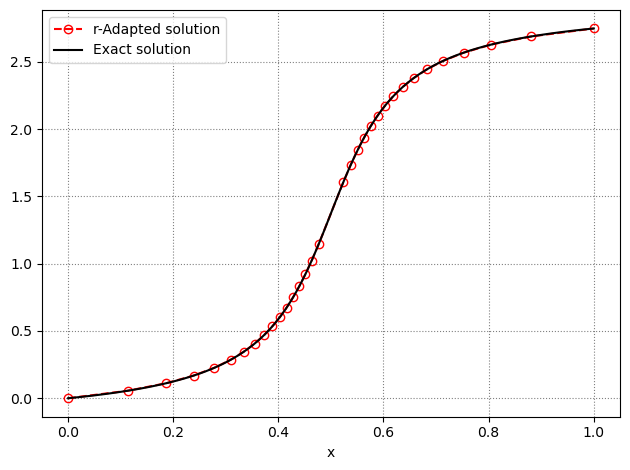

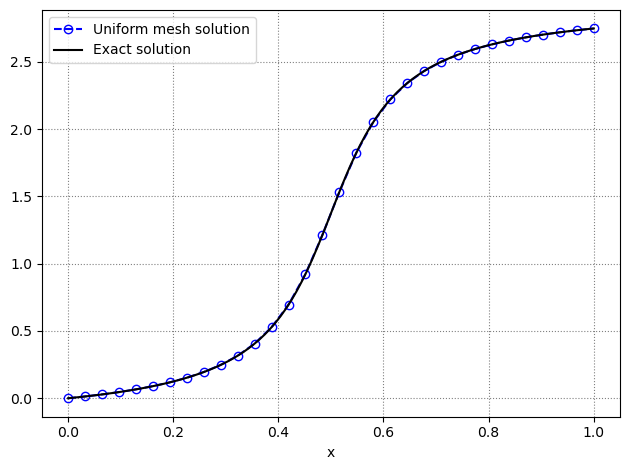

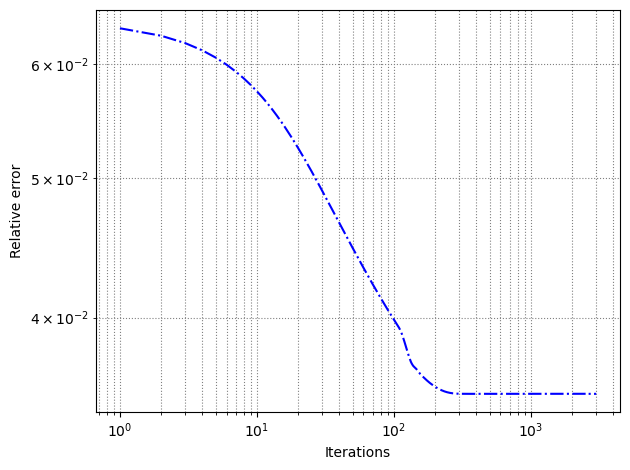

In [34]:
# Plot results
uniform_nodes = jnp.linspace(0, 1, nn)

node_coords, u = solve(model(jnp.array([1])))
uniform_coords, o = solve(uniform_nodes)
x = np.linspace(0, 1, 100)
y = np.arctan(10*(x-0.5)) + np.arctan(10*0.5)

J_u_theta = np.array(history.history['loss'])
J_u       = Exact_Ritz()
J_u_h = solve_and_loss(uniform_nodes)
rel_error_theta = np.sqrt((J_u - J_u_theta)/J_u)
rel_error_h = np.sqrt((J_u - J_u_h)/J_u)
print('e_h:', rel_error_h)
print('e_theta:', rel_error_theta[-1])

# Plot the approximate solution obtained from the trained model
plt.figure(1)
plt.plot(node_coords, u,'o--', color='r', fillstyle='none')
plt.plot(x, y, color='k')
plt.xlabel('x')
plt.legend(['r-Adapted solution', 'Exact solution'])
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot the approximate solution obtained from the uniform mesh
plt.figure(2)
plt.plot(uniform_coords, o, 'o--', color='b', fillstyle='none')
plt.plot(x, y, color='k')
plt.xlabel('x')
plt.legend(['Uniform mesh solution', 'Exact solution'])
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot the relative error
plt.figure(3)
plt.loglog(np.arange(1,iterations+1), rel_error_theta,'-.', color='b')
plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

plt.show()